In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

LOAD DATA

In [2]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
                    for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                    for x in ['train', 'val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

VISUALIZE SOME IMAGES

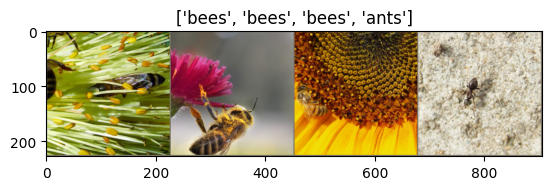

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# get a bunch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

TRAINING THE MODEL

write a generic function to train a model

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 2}")
        print("-" * 10)

        # each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()   # set model to training mode
            else:
                model.eval()    # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward 
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)   
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_loss >best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # loas best model weights
    model.load_state_dict(best_model_wts)
    return model
            

VISUALIZING THE MODEL PREDICTIONS
function to display predictions for a few images

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


FINETUNING THE CONVNET

load a pretrained model and reset the final fully connected layer